# Лабораторная работа №2 по курсу Deep Learning 

Выполнил: **Борисов Алексей**

### Аннотация

В данном задании реализуем собственный вариант контекстных представлений (эмбеддингов) на основе языковых моделей, созданных с помощью рекуррентной нейронной сети.
Для оценки качества полученных представлений будем использовать данные соревнования [Toxic Comment Classification Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge). Также проведем анализ того как в полученных представлениях учитывается контекст.

Основные вопросы, которые ставит перед собой работа:

* Дает ли использование контекстных эмбеддингов какое-то преимущество по сравнению с неконтекстными?
* Как качество представлений зависит от из размерности?
* Действительно ли происходит учет контекста?

## Модель контекстных эмбеддингов

Модель, которую мы будем использовать для получения контекстных эмбеддингов, использует идеи из [ELMo](https://arxiv.org/pdf/1802.05365.pdf) представлений. Прежде всего происходит обучение двух языковых моделей, первая предсказывает следующее слово по всем предыдущим, а вторая предыдущее по всем следующим. Для обучения языковых моделей используются сети LSTM. Таким образом, скрытые представления в LSTM формируют некоторое представление слова, принимая во внимание его "левый" и "правый" контексты соответсвенно. 

<img src="./assets/ELMO_vis.png" width="1000">

Импортируем все необходимые модули и функции.

In [18]:
import os
import sys
import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchtext
import nltk
nltk.download('punkt', quiet=True)
import gensim.downloader

from collections import Counter
from functools import partial

from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, roc_auc_score, RocCurveDisplay

from data_utils import get_vocab, collate_fn, CommentsDataset, tokenize
from elmo_utils import ELMo, train_lm, LMCrossEntropyLoss, LMAccuracy, get_embeddings, decode
from elmo_utils import token_info, show_token_info, raw_text_embeddings, get_nearest_texts

dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


## Поготовка данных

Данные представляют собой комментарии из Википедии со страниц редактирования. Комментарии делятся на токсичные и нетоксичные. Эту их характеристику мы далее будем предсказывать для оценки качества полученных контекстных представлений.

In [3]:

train_data = pd.read_csv('./data/train.csv').drop(['id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)
val_data = pd.read_csv('./data/test.csv').drop(['id'], axis=1)
val_labels = pd.read_csv('./data/test_labels.csv').drop(['id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)

val_data = pd.concat((val_data[val_labels.toxic != -1], val_labels[val_labels.toxic != -1]), axis=1)
val_data.index = np.arange(val_data.shape[0])

merged_data =  pd.concat((train_data, val_data), axis=0) # only for vocab creation
merged_data.index = np.arange(merged_data.shape[0])
merged_data.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Ограничим размер словаря 15_000 токенами, этого кажется более чем достаточно для получения небольшой языковой модели. При обработке текстов в словарь кроме слов были также добавлены знаки препинания и другие последовательности символов, которые использовались в комментариях. Это будет далее видно при визуальной оценке текстов, которые генерируют обученные языковые модели. 

In [3]:
VOCAB_SIZE = 15_000
vocab = get_vocab(merged_data, vocab_size=VOCAB_SIZE, sos_eos=True)

MAX_LEN = 100
val_dataset = CommentsDataset(val_data, vocab, MAX_LEN, pad_sos=True, pad_eos=True)
train_dataset = CommentsDataset(train_data, vocab, MAX_LEN, pad_sos=True, pad_eos=True)

torch.save(train_dataset, "./data/train_dataset.torch")
torch.save(val_dataset, "./data/val_dataset.torch")
torch.save(vocab, "./data/vocab.torch")

  0%|          | 0/223549 [00:00<?, ?it/s]

  0%|          | 0/63978 [00:00<?, ?it/s]

  0%|          | 0/159571 [00:00<?, ?it/s]

## Обучение языковых моделей

Загрузим необходимые данные. Так как данные представляют собой комментарии, то представления слов, предобученные на постах из твиттера должны быть довольно неплохими. Ограничимся самыми маленькими предобученными представлениями размера 25. Для их получения использовалась модель GloVe.

In [4]:

pretrained_embeddings = gensim.downloader.load('glove-twitter-25')
vocab = torch.load("./data/vocab.torch")
train_dataset = torch.load("./data/train_dataset.torch")
val_dataset = torch.load("./data/val_dataset.torch")

correct_collate_fn = partial(collate_fn, padding_value=0, batch_first=False)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                             num_workers=0, collate_fn=correct_collate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                             num_workers=0, collate_fn=correct_collate_fn)

Размерность контекстных эмбеддингов напрямую зависит от размерности скрытого слоя в сетях LSTM, которые используются для создания языковых моделей.
Обучим языковые модели со следующими размерами скрытого слоя: 16, 32, 64, 128. В оригинальной статье посвященной ELMo использовались двухслойные LSTM, мы же ограничимся одним слоем. Также отметим, что при обучении языковых моделей, мы будем дообучать предобученные неконтекстные представления.

In [5]:

params = {
    'embedding_dim': 25,
    'vocab': vocab,
    'pretrained_embeddings': pretrained_embeddings,
    'tuning': True,
    'dropout': 0.0,
    'num_layers': 1
}

loss_fn = LMCrossEntropyLoss(reduction='mean')

Было решено оставить выводы при обучении. Эта информация кажется полезной, так как отражает изменения лосса и точности при обучении языковых моделей, а также позволяет сравнить `forward` и `backward` модели.

In [19]:
# hidden_dim = 16

model_16 = ELMo(hidden_dim=16, **params).to(device=device)
optimizer = torch.optim.Adam([ param for param in model_16.parameters() if param.requires_grad == True], lr=0.005, weight_decay=1.2e-6)
history_16 = train_lm(
    train_dataloader, val_dataloader, model_16, loss_fn, optimizer, device, 10
)
model_16.cpu()
torch.save(model_16.state_dict(), "./model_16.torch")
torch.save(history_16, "./history_16.torch")

FORWARD: Epoch: 1/10. Loss (Train/Val): 5.191/5.255. Accuracy (Train/Val): 0.178/0.180
BACKWARD: Epoch: 1/10. Loss (Train/Val): 5.212/5.298. Accuracy (Train/Val): 0.184/0.184
FORWARD: Epoch: 2/10. Loss (Train/Val): 5.072/5.151. Accuracy (Train/Val): 0.188/0.189
BACKWARD: Epoch: 2/10. Loss (Train/Val): 5.100/5.194. Accuracy (Train/Val): 0.194/0.194
FORWARD: Epoch: 3/10. Loss (Train/Val): 5.023/5.115. Accuracy (Train/Val): 0.193/0.194
BACKWARD: Epoch: 3/10. Loss (Train/Val): 5.049/5.154. Accuracy (Train/Val): 0.198/0.197
FORWARD: Epoch: 4/10. Loss (Train/Val): 4.999/5.093. Accuracy (Train/Val): 0.195/0.197
BACKWARD: Epoch: 4/10. Loss (Train/Val): 5.021/5.123. Accuracy (Train/Val): 0.202/0.202
FORWARD: Epoch: 5/10. Loss (Train/Val): 4.984/5.087. Accuracy (Train/Val): 0.197/0.197
BACKWARD: Epoch: 5/10. Loss (Train/Val): 5.001/5.103. Accuracy (Train/Val): 0.203/0.204
FORWARD: Epoch: 6/10. Loss (Train/Val): 4.973/5.075. Accuracy (Train/Val): 0.198/0.199
BACKWARD: Epoch: 6/10. Loss (Train/Val

In [17]:
# hidden_dim = 32

model_32 = ELMo(hidden_dim=32, **params).to(device=device)
optimizer = torch.optim.Adam([ param for param in model_32.parameters() if param.requires_grad == True], lr=0.005, weight_decay=1.2e-6)
history_32 = train_lm(
    train_dataloader, val_dataloader, model_32, loss_fn, optimizer, device, 10
)
model_32.cpu()
torch.save(model_32.state_dict(), "./model_32.torch")
torch.save(history_32, "./history_32.torch")

FORWARD: Epoch: 1/10. Loss (Train/Val): 5.022/5.100. Accuracy (Train/Val): 0.193/0.196
BACKWARD: Epoch: 1/10. Loss (Train/Val): 5.025/5.118. Accuracy (Train/Val): 0.199/0.195
FORWARD: Epoch: 2/10. Loss (Train/Val): 4.888/4.991. Accuracy (Train/Val): 0.206/0.206
BACKWARD: Epoch: 2/10. Loss (Train/Val): 4.879/4.979. Accuracy (Train/Val): 0.214/0.214
FORWARD: Epoch: 3/10. Loss (Train/Val): 4.828/4.939. Accuracy (Train/Val): 0.213/0.212
BACKWARD: Epoch: 3/10. Loss (Train/Val): 4.825/4.937. Accuracy (Train/Val): 0.220/0.218
FORWARD: Epoch: 4/10. Loss (Train/Val): 4.799/4.915. Accuracy (Train/Val): 0.216/0.215
BACKWARD: Epoch: 4/10. Loss (Train/Val): 4.796/4.913. Accuracy (Train/Val): 0.223/0.221
FORWARD: Epoch: 5/10. Loss (Train/Val): 4.779/4.903. Accuracy (Train/Val): 0.218/0.217
BACKWARD: Epoch: 5/10. Loss (Train/Val): 4.777/4.904. Accuracy (Train/Val): 0.225/0.222
FORWARD: Epoch: 6/10. Loss (Train/Val): 4.767/4.892. Accuracy (Train/Val): 0.220/0.217
BACKWARD: Epoch: 6/10. Loss (Train/Val

In [20]:
# hidden_dim = 64

model_64 = ELMo(hidden_dim=64, **params).to(device=device)
optimizer = torch.optim.Adam([ param for param in model_64.parameters() if param.requires_grad == True], lr=0.005, weight_decay=1.2e-6)
history_64 = train_lm(
    train_dataloader, val_dataloader, model_64, loss_fn, optimizer, device, 10
)
model_64.cpu()
torch.save(model_64.state_dict(), "./model_64.torch")
torch.save(history_64, "./history_64.torch")

FORWARD: Epoch: 1/10. Loss (Train/Val): 4.814/4.920. Accuracy (Train/Val): 0.214/0.213
BACKWARD: Epoch: 1/10. Loss (Train/Val): 4.840/4.955. Accuracy (Train/Val): 0.217/0.215
FORWARD: Epoch: 2/10. Loss (Train/Val): 4.676/4.810. Accuracy (Train/Val): 0.230/0.227
BACKWARD: Epoch: 2/10. Loss (Train/Val): 4.702/4.834. Accuracy (Train/Val): 0.233/0.229
FORWARD: Epoch: 3/10. Loss (Train/Val): 4.617/4.767. Accuracy (Train/Val): 0.236/0.231
BACKWARD: Epoch: 3/10. Loss (Train/Val): 4.644/4.791. Accuracy (Train/Val): 0.239/0.234
FORWARD: Epoch: 4/10. Loss (Train/Val): 4.587/4.740. Accuracy (Train/Val): 0.240/0.234
BACKWARD: Epoch: 4/10. Loss (Train/Val): 4.610/4.757. Accuracy (Train/Val): 0.243/0.238
FORWARD: Epoch: 5/10. Loss (Train/Val): 4.571/4.727. Accuracy (Train/Val): 0.241/0.234
BACKWARD: Epoch: 5/10. Loss (Train/Val): 4.589/4.738. Accuracy (Train/Val): 0.246/0.240
FORWARD: Epoch: 6/10. Loss (Train/Val): 4.553/4.717. Accuracy (Train/Val): 0.244/0.237
BACKWARD: Epoch: 6/10. Loss (Train/Val

In [21]:
# hidden_dim = 128

model_128 = ELMo(hidden_dim=128, **params).to(device=device)
optimizer = torch.optim.Adam([ param for param in model_128.parameters() if param.requires_grad == True], lr=0.005, weight_decay=1.2e-6)
history_128 = train_lm(
    train_dataloader, val_dataloader, model_128, loss_fn, optimizer, device, 10
)
model_128.cpu()
torch.save(model_128.state_dict(), "./model_128.torch")
torch.save(history_128, "./history_128.torch")

FORWARD: Epoch: 1/10. Loss (Train/Val): 4.633/4.774. Accuracy (Train/Val): 0.235/0.230
BACKWARD: Epoch: 1/10. Loss (Train/Val): 4.612/4.751. Accuracy (Train/Val): 0.243/0.238
FORWARD: Epoch: 2/10. Loss (Train/Val): 4.491/4.657. Accuracy (Train/Val): 0.249/0.241
BACKWARD: Epoch: 2/10. Loss (Train/Val): 4.477/4.644. Accuracy (Train/Val): 0.257/0.250
FORWARD: Epoch: 3/10. Loss (Train/Val): 4.432/4.607. Accuracy (Train/Val): 0.255/0.247
BACKWARD: Epoch: 3/10. Loss (Train/Val): 4.423/4.602. Accuracy (Train/Val): 0.263/0.254
FORWARD: Epoch: 4/10. Loss (Train/Val): 4.392/4.583. Accuracy (Train/Val): 0.260/0.250
BACKWARD: Epoch: 4/10. Loss (Train/Val): 4.384/4.573. Accuracy (Train/Val): 0.268/0.258
FORWARD: Epoch: 5/10. Loss (Train/Val): 4.371/4.560. Accuracy (Train/Val): 0.262/0.252
BACKWARD: Epoch: 5/10. Loss (Train/Val): 4.364/4.554. Accuracy (Train/Val): 0.270/0.260
FORWARD: Epoch: 6/10. Loss (Train/Val): 4.362/4.557. Accuracy (Train/Val): 0.263/0.253
BACKWARD: Epoch: 6/10. Loss (Train/Val

Отметим ***интересную закономерность***, которая была обнаружена при обучении языковых моделей: точность предсказания предыдущего слова по следующим всегда получается выше чем точность предсказания следующего слова по предыдущим. (Так как при одном числе эпох модель `backward` имеет большую точность)

Также с ростом размерности скрытого слоя точность языковой модели повышается.

Возьмем одну из моделей и посмотрим на качество генерируемых текстов моделями `forward` и `backward`.

In [7]:
%%capture
model = ELMo(hidden_dim=128, **params).to('cpu')
model.load_state_dict(torch.load("./model_128.torch"))
model.eval()

`forward` модель.

In [42]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', 'please', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'you', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'i', 'hate', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'i', 'love', '<pad>']),
]).T

start_tokens_lens = torch.tensor([2, 2, 3, 3])

decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=10, mode='forward')

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> please stop . if you nigger to company wikipedia , you will be under from many . talk <eos>
<sos> you pages a support email you pages a gay anyway <eos>
<sos> i hate . you pages list to than a life , you will be the → its you and i hate you
<sos> i love . ( talk to me ) <eos>


`backward` модель

In [93]:
end_tokens = torch.tensor([
    model.vocab.lookup_indices(['<eos>', 'please', 'me', 'help']),
    model.vocab.lookup_indices(['<eos>', 'you', 'hate', '<pad>']),
    model.vocab.lookup_indices(['<eos>', 'you', 'love', '<pad>']),
]).T

end_tokens_lens = torch.tensor([3, 3, 3])

decoded_tokens, decoded_lens = decode(model, end_tokens, end_tokens_lens, max_generated_len=200, top_k=10, mode='backward')

for text_idx in range(end_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = end_tokens[:end_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    start_positions = torch.argwhere(torch.tensor(tokens) == 2)
    if start_positions.numel() != 0:
        start_token = start_positions[0]
        tokens = tokens[:start_token + 1]
    words = np.array(model.vocab.get_itos())[np.array(tokens)[::-1]]
    print(' '.join(words))

<sos> you are mosca with you and her to help need and if you would like to wonder with the date . if you can internet me please <eos>
<sos> i sources to kill you ! do n't like you , , but i hate you <eos>
<sos> its you , i do relevant wikipedia ! ! ! ! ! ! ! thanks you please post it on now talk page . in the love you <eos>


Видно, что предложения получаются грамматически похожими на естественные. Модель даже научилась закрывать открытые скобки.

## Качественная оценка представлений

В качестве контекстных представлений будем использовать просто конкатенацию скрытых слоев из моделей `forward` и `backward`. 
Попробуем оценить качество этих представлений не с точки зрения точности на каких-то конкретных задачах, а исследуем обладают ли эти представления свойствами, которые мы хотели бы иметь у контекстных представлений.

Одна из мотиваций использования контекстных представлений заключается в том, что одинаково пишущиеся слова могут обладать разным смыслом (омонимы), и заранее предобученные векторные представления для таких слов не отражают разные смыслы. Исследуем обладают ли полученные представления таким свойством, что "группируют" представления по смыслам.

Проведем следующие эксперименты:

* Сами сформируем предложения, в которых слово встречается в разных смыслах, и найдем предложения в данных, в которых встречаются слова со схожим векторным представлением. Схожими векторными представлениями должно обладать это же слово, при использовании в том же смысле.
* Выделим все представления конкретного токена и попробуем их кластеризовать и визуализировать. При наличии ярко выраженных кластеров попытаемся выяснить их природу.

Заранее посчитаем представления для всех токенов всех предложений. Пока что будем использовать ту же модель со скрытым слоем размерности 128 (размер представлений 256).

In [8]:
model.cuda()

all_embeddings = []

for elem in tqdm(val_dataset):
    
    tokens, reversed_tokens, tokens_lens = elem['tokens'], elem['reversed_tokens'], elem['tokens_len']
    tokens, reversed_tokens, tokens_lens = tokens.reshape(-1, 1), reversed_tokens.reshape(-1, 1), tokens_lens.reshape(1)
    tokens, reversed_tokens = tokens.to(device), reversed_tokens.to(device)
    
    with torch.no_grad():
        cur_embeddings = get_embeddings(model, tokens, reversed_tokens, tokens_lens)[:, 0, :].cpu()
    all_embeddings.append(cur_embeddings)

  0%|          | 0/63978 [00:00<?, ?it/s]

Слово `Washington` используется в разных значениях, например 1-й президент США Джордж Вашингтон и штат Вашингтон. Сформулируем предложения с этими смыслами и найдем ближайшие.

In [235]:
model.cpu()
text = "President Washington was the best president in the world"
embeddings_president = raw_text_embeddings(model, text, vocab, device='cpu')

text = "I am from Washington state."
embeddings_state = raw_text_embeddings(model, text, vocab, device='cpu')

In [242]:
chosen_embedding = embeddings_president[2]

texts_president, positions_president = get_nearest_texts(model, chosen_embedding, all_embeddings)

  0%|          | 0/63978 [00:00<?, ?it/s]

In [243]:
chosen_embedding = embeddings_state[4]

texts_state, positions_state = get_nearest_texts(model, chosen_embedding, all_embeddings)

  0%|          | 0/63978 [00:00<?, ?it/s]

Выведем фрагменты текста, в которых (исходя из близости контекстных представлений) слово `washington` употреблено в значении президента и штата соответственно. Слово `washington` выделено заглавными буквами.

In [286]:
stride = 10

for i in range(5):
    left = max(0, positions_president[i].long() - stride)
    right = positions_president[i].long() + stride
    cur_text_part = val_dataset[texts_president[i].long()]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions_president[i].long() - left] = cur_text_part[positions_president[i].long() - left].upper()
    print(f"TEXT {i+1}: {' '.join(cur_text_part)}")

TEXT 1: online fundraising is something new and unexpected - `` '' WASHINGTON do n't know what to make of it .
TEXT 2: structure the article based on the sections of the george WASHINGTON , malcolm x , gandhi , james i of
TEXT 3: the american revolution , presidency of george washington , george WASHINGTON 's legacy , cultural depictions of george washington ,
TEXT 4: george washington in the american revolution , presidency of george WASHINGTON , george washington 's legacy , cultural depictions of
TEXT 5: and who is able to manage it ... did george WASHINGTON chop down the cherry tree ? there still teaching


In [287]:
stride = 10

for i in range(5):
    left = max(0, positions_state[i].long() - stride)
    right = positions_state[i].long() + stride
    cur_text_part = val_dataset[texts_state[i].long()]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions_state[i].long() - left] = cur_text_part[positions_state[i].long() - left].upper()
    print(f"TEXT {i+1}: {' '.join(cur_text_part)}")

TEXT 1: : what ? sr is a state highway defined by WASHINGTON state law that motor vehicles are not allowed on
TEXT 2: <sos> , also developed in WASHINGTON state <eos>
TEXT 3: anyone have the date on the bradley post of the WASHINGTON post , and can anyone find any other articles
TEXT 4: from virginia ? i always thought that they were from WASHINGTON . <eos>
TEXT 5: and a lot of the went to a hotel in WASHINGTON dc . i thought i remember reading that the


Как мы видим, контекстные представления оправдали ожидания! Несмотря на то, что в нашем предложении не было упоминания `george`, языковая модель определила, что он и есть `president Washington`. В первом примере скорее всего речь шла не о Джордже Вашингтоне, но слово употребляется в качестве подлежащего и выполняет действие, поэтому понятно почему его представление оказалось близким к контексту президента.

В случае штата снова успех, по контекстам `washington state`, `washington dc`, `from washington` языковая модель "поняла", что речь идет о месте. Также близким оказался контекст с `washington post`, что в принципе тоже разумно, так как здесь washington означает географическую принадлежность.

Рассмотрим еще один пример. Слово `her` может употребляться в 2 разных значениях: её (её книга) и ей (помочь ей). Проведем действия аналогичные предыдущему эксперименту с `washington`.

In [426]:
model.cpu()
text = "I want to help her."
embeddings_help = raw_text_embeddings(model, text, vocab, device='cpu')

text = "This is her book."
embeddings_book = raw_text_embeddings(model, text, vocab, device='cpu')

In [427]:
chosen_embedding = embeddings_help[5]

texts_help, positions_help = get_nearest_texts(model, chosen_embedding, all_embeddings)

  0%|          | 0/63978 [00:00<?, ?it/s]

In [428]:
chosen_embedding = embeddings_book[3]

texts_book, positions_book = get_nearest_texts(model, chosen_embedding, all_embeddings)

  0%|          | 0/63978 [00:00<?, ?it/s]

In [434]:
stride = 10

for i in range(5):
    left = max(0, positions_help[i].long() - stride)
    right = positions_help[i].long() + stride
    cur_text_part = val_dataset[texts_help[i].long()]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions_help[i].long() - left] = cur_text_part[positions_help[i].long() - left].upper()
    print(f"TEXT {i+1}: {' '.join(cur_text_part)}")

TEXT 1: sexist towards her which is probably not going to help HER . <eos>
TEXT 2: is contrary to what people want you to know about HER . <eos>
TEXT 3: nothing to do with us . i do n't blame HER . you bring your issues to her for what
TEXT 4: she gets to sleep with brandon boyd . i envy HER . <eos>
TEXT 5: <sos> ! man , i hate HER . <eos>


In [435]:
stride = 10

for i in range(5):
    left = max(0, positions_book[i].long() - stride)
    right = positions_book[i].long() + stride
    cur_text_part = val_dataset[texts_book[i].long()]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions_book[i].long() - left] = cur_text_part[positions_book[i].long() - left].upper()
    print(f"TEXT {i+1}: {' '.join(cur_text_part)}")

TEXT 1: her book or . give me an example of in HER book . she 's `` '' hang the jew
TEXT 2: <sos> an atlas of impossible should be added as HER latest book . <eos>
TEXT 3: <sos> == did this article come from HER website ? == i only ask because it reads
TEXT 4: <sos> also HER new song is : touch my body a new
TEXT 5: to me like a highly depiction of the controversy over HER first book . i do n't think she would


Как мы видим, снова ближайшими представлениями оказываются те же слова в нужных контекстах. 

Теперь возьмем несколько слов, смысл которых может меняться от контекста и попробуем их кластеризовать с помощью KMeans и визулизировать с помощью t-SNE. Если на визуализации будут выделяться кластеры, то попробуем выяснить их природу (совпадает ли она с предположенной). 

Рассмотрим следующие слова:
* `post` может употребляться как в качестве существительного, так и в качестве глагола.
* `piece` - разные значения: кусок чего-либо, пьеса и другие.
* `her` - "её книга" и "помочь ей". В обоих случаях в английском используется `her`.

`post`

  0%|          | 0/63978 [00:00<?, ?it/s]

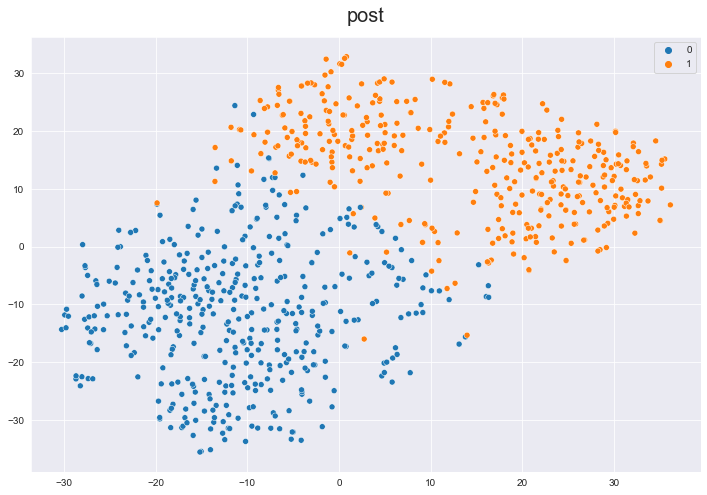

In [58]:
token = "post"
texts, positions, all_token_embeddings = token_info(token, vocab, val_dataset, all_embeddings)
y_pred = show_token_info(all_token_embeddings, title=token)

In [59]:
stride = 10
max_count = 5
cur_count = 0

indices = torch.argwhere(torch.tensor(y_pred == 0)).ravel()
r = torch.randperm(indices.shape[0])

for i in indices[r]:
    if cur_count == max_count:
        break
    left = max(0, positions[i] - stride)
    right = positions[i] + stride
    text_idx = texts[i]
    cur_text_part = val_dataset[text_idx]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions[i] - left] = cur_text_part[positions[i] - left].upper()
    cur_count += 1
    print(f"TEXT {cur_count}: {' '.join(cur_text_part)}")

TEXT 1: this is all fake his wife is really a lamp POST and he has a pet if he ever eats
TEXT 2: posts - however , a bit of digging reveals the POST for the win ) . but you have to
TEXT 3: late reply - been busy . replying to the original POST : text on this topic should normally go under
TEXT 4: significantly revised and changed since the time of the initial POST of this thread on 19 july 2012. `` <eos>
TEXT 5: : : : : ok , i 'm ignoring the POST now too . ; ) - <eos>


In [60]:
stride = 10
max_count = 5
cur_count = 0

indices = torch.argwhere(torch.tensor(y_pred == 1)).ravel()
r = torch.randperm(indices.shape[0])

for i in indices[r]:
    if cur_count == max_count:
        break
    left = max(0, positions[i] - stride)
    right = positions[i] + stride
    text_idx = texts[i]
    cur_text_part = val_dataset[text_idx]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions[i] - left] = cur_text_part[positions[i] - left].upper()
    cur_count += 1
    print(f"TEXT {cur_count}: {' '.join(cur_text_part)}")

TEXT 1: do what i can to address your concerns and will POST a note here when i have done so .
TEXT 2: he did n't leave the message he said he would POST and he is now retired . i know it
TEXT 3: ready in the next couple of days , and will POST it in my user sandbox . <eos>
TEXT 4: <sos> `` i can not POST ? == hello , i 've tried 3 times
TEXT 5: . one can request a third opinion , or even POST an inquiry at one of the wikiprojects listed above


Кластеры хотя и не очень четкие, но выделяются. У них простая природа, в одном `post` используется в качестве глагола (`to post`, `will post`), а во втором в качестве существительного.

`piece`

  0%|          | 0/63978 [00:00<?, ?it/s]

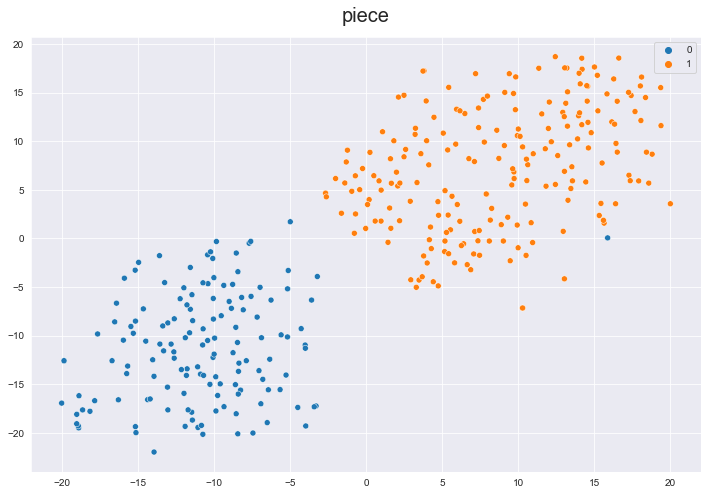

In [61]:
token = "piece"
texts, positions, all_token_embeddings = token_info(token, vocab, val_dataset, all_embeddings)
y_pred = show_token_info(all_token_embeddings, title=token)

In [63]:
stride = 10
max_count = 5
cur_count = 0

indices = torch.argwhere(torch.tensor(y_pred == 0)).ravel()
r = torch.randperm(indices.shape[0])

for i in indices[r]:
    if cur_count == max_count:
        break
    left = max(0, positions[i] - stride)
    right = positions[i] + stride
    text_idx = texts[i]
    cur_text_part = val_dataset[text_idx]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions[i] - left] = cur_text_part[positions[i] - left].upper()
    cur_count += 1
    print(f"TEXT {cur_count}: {' '.join(cur_text_part)}")

TEXT 1: on now - promise . and i like the william PIECE on your user page . . <eos>
TEXT 2: on wikipedia . the entire article reads like a hit PIECE on . it needs a complete rewrite into npov
TEXT 3: it 's fine to cite top gear , since each PIECE they do is supposed to be factual and of
TEXT 4: very least . i have just tried to read through PIECE above , and i left a comment . i
TEXT 5: error , in fact , that if true the entire PIECE useless . if the times piece is correct ,


In [66]:
stride = 10
max_count = 5
cur_count = 0

indices = torch.argwhere(torch.tensor(y_pred == 1)).ravel()
r = torch.randperm(indices.shape[0])

for i in indices[r]:
    if cur_count == max_count:
        break
    left = max(0, positions[i] - stride)
    right = positions[i] + stride
    text_idx = texts[i]
    cur_text_part = val_dataset[text_idx]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions[i] - left] = cur_text_part[positions[i] - left].upper()
    cur_count += 1
    print(f"TEXT {cur_count}: {' '.join(cur_text_part)}")

TEXT 1: included in main article the of is a man made PIECE of bearing an image of a man that has
TEXT 2: hl ; =en i have tried to include this relevant PIECE of information on the actual flower drum song wikipedia
TEXT 3: in their minds . i would be redirecting this particular PIECE of rubbish to relations as it is a of
TEXT 4: <sos> : :it 's a PIECE of garbage article written by his followers , who
TEXT 5: behind keeping the article unbiased , just because of a PIECE of phrase that was poorly worded . it would


Очень четко отделяются кластеры! И их природа снова довольно простая. В одном находятся использования слова `piece` в контексте `piece of something` (кусок чего-либо), а во втором кластере видимо все остальные вхождения этого слова.

`her`

  0%|          | 0/63978 [00:00<?, ?it/s]

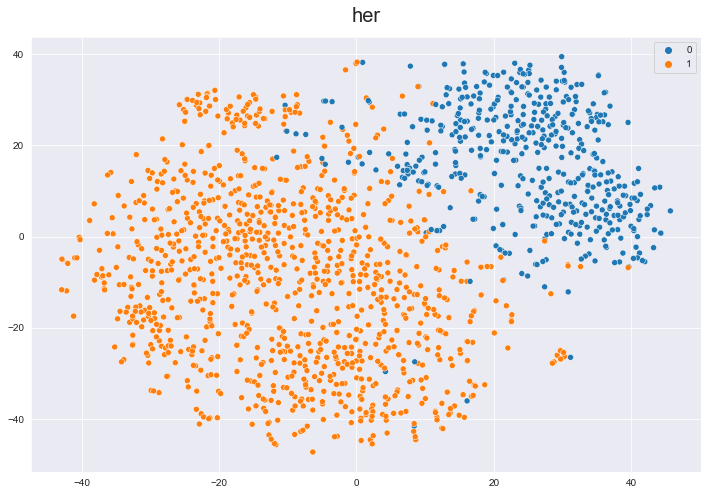

In [67]:
token = "her"
texts, positions, all_token_embeddings = token_info(token, vocab, val_dataset, all_embeddings)
y_pred = show_token_info(all_token_embeddings, title=token)

In [70]:
stride = 10
max_count = 5
cur_count = 0

indices = torch.argwhere(torch.tensor(y_pred == 0)).ravel()
r = torch.randperm(indices.shape[0])

for i in indices[r]:
    if cur_count == max_count:
        break
    left = max(0, positions[i] - stride)
    right = positions[i] + stride
    text_idx = texts[i]
    cur_text_part = val_dataset[text_idx]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions[i] - left] = cur_text_part[positions[i] - left].upper()
    cur_count += 1
    print(f"TEXT {cur_count}: {' '.join(cur_text_part)}")

TEXT 1: are just , that is interesting that your daughter is HER in that manner . of : : : :
TEXT 2: it is probably not advisable to be adding him or HER to a list of . in addition , these
TEXT 3: volume 8 , proposes to , asking him to marry HER . also to that she loves her . ''
TEXT 4: she took from had brought it with him to kill HER ) and cuts his . '' '' who had
TEXT 5: , perhaps on both . i have n't talked to HER in a while , so i do n't really


In [69]:
stride = 10
max_count = 5
cur_count = 0

indices = torch.argwhere(torch.tensor(y_pred == 1)).ravel()
r = torch.randperm(indices.shape[0])

for i in indices[r]:
    if cur_count == max_count:
        break
    left = max(0, positions[i] - stride)
    right = positions[i] + stride
    text_idx = texts[i]
    cur_text_part = val_dataset[text_idx]['tokens'][left : right]
    cur_text_part = vocab.lookup_tokens(cur_text_part.tolist())
    cur_text_part[positions[i] - left] = cur_text_part[positions[i] - left].upper()
    cur_count += 1
    print(f"TEXT {cur_count}: {' '.join(cur_text_part)}")

TEXT 1: almost the same way of thinking anyone can agree that HER sales are about : mariah carey : million million
TEXT 2: sense . it does not and should not apply to HER album . she did not release any other album
TEXT 3: people to be at the and per wp : undue HER mention could be removed . also the edit mentions
TEXT 4: . its largely a from either the main article or HER discography article , so i assume it is fine
TEXT 5: piece of fucking , filthy shit who spends most of HER time either on the or at a . she


Кластеры выделяются, хотя и не очень четко. Их природа соответствует предположенной: `her` в значениях "её" и "ей".

## Сравнение в зависимости от размера контекстных представлений

Хотя кажется и не очень корректным так визуально сравнивать разные языковые модели, так как модели могли выучить просто различные зависимости в данных, но сделаем такие же визуализации для контекстных представлений других размеров (из других языковых моделей).

In [81]:

model_16 = ELMo(hidden_dim=16, **params).to('cpu')
model_16.load_state_dict(torch.load("./model_16.torch"))
model_16.eval()
model_16.cuda()

all_embeddings_16 = []

for elem in tqdm(val_dataset):
    
    tokens, reversed_tokens, tokens_lens = elem['tokens'], elem['reversed_tokens'], elem['tokens_len']
    tokens, reversed_tokens, tokens_lens = tokens.reshape(-1, 1), reversed_tokens.reshape(-1, 1), tokens_lens.reshape(1)
    tokens, reversed_tokens = tokens.to(device), reversed_tokens.to(device)
    
    with torch.no_grad():
        cur_embeddings = get_embeddings(model_16, tokens, reversed_tokens, tokens_lens)[:, 0, :].cpu()
    all_embeddings_16.append(cur_embeddings)

  0%|          | 0/63978 [00:00<?, ?it/s]

In [82]:

model_32 = ELMo(hidden_dim=32, **params).to('cpu')
model_32.load_state_dict(torch.load("./model_32.torch"))
model_32.eval()
model_32.cuda()

all_embeddings_32 = []

for elem in tqdm(val_dataset):
    
    tokens, reversed_tokens, tokens_lens = elem['tokens'], elem['reversed_tokens'], elem['tokens_len']
    tokens, reversed_tokens, tokens_lens = tokens.reshape(-1, 1), reversed_tokens.reshape(-1, 1), tokens_lens.reshape(1)
    tokens, reversed_tokens = tokens.to(device), reversed_tokens.to(device)
    
    with torch.no_grad():
        cur_embeddings = get_embeddings(model_32, tokens, reversed_tokens, tokens_lens)[:, 0, :].cpu()
    all_embeddings_32.append(cur_embeddings)

  0%|          | 0/63978 [00:00<?, ?it/s]

In [83]:

model_64 = ELMo(hidden_dim=64, **params).to('cpu')
model_64.load_state_dict(torch.load("./model_64.torch"))
model_64.eval()
model_64.cuda()

all_embeddings_64 = []

for elem in tqdm(val_dataset):
    
    tokens, reversed_tokens, tokens_lens = elem['tokens'], elem['reversed_tokens'], elem['tokens_len']
    tokens, reversed_tokens, tokens_lens = tokens.reshape(-1, 1), reversed_tokens.reshape(-1, 1), tokens_lens.reshape(1)
    tokens, reversed_tokens = tokens.to(device), reversed_tokens.to(device)
    
    with torch.no_grad():
        cur_embeddings = get_embeddings(model_64, tokens, reversed_tokens, tokens_lens)[:, 0, :].cpu()
    all_embeddings_64.append(cur_embeddings)

  0%|          | 0/63978 [00:00<?, ?it/s]

`post`

  0%|          | 0/63978 [00:00<?, ?it/s]

  0%|          | 0/63978 [00:00<?, ?it/s]

  0%|          | 0/63978 [00:00<?, ?it/s]

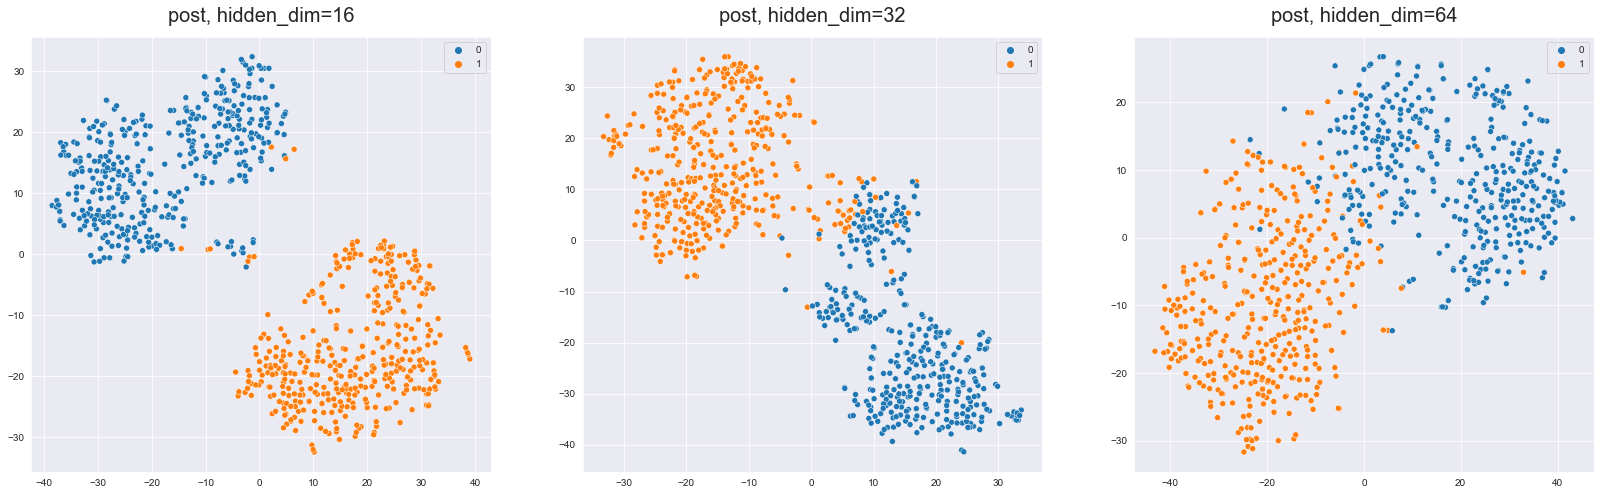

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 8))
axes = axes.ravel()

token = "post"
# 16
texts, positions, all_token_embeddings_16 = token_info(token, vocab, val_dataset, all_embeddings_16)
y_pred = show_token_info(all_token_embeddings_16, title=token + ", hidden_dim=16", ax=axes[0])
# 32
texts, positions, all_token_embeddings_32 = token_info(token, vocab, val_dataset, all_embeddings_32)
y_pred = show_token_info(all_token_embeddings_32, title=token + ", hidden_dim=32", ax=axes[1])
# 64
texts, positions, all_token_embeddings_64 = token_info(token, vocab, val_dataset, all_embeddings_64)
y_pred = show_token_info(all_token_embeddings_64, title=token + ", hidden_dim=64", ax=axes[2])

`piece`

  0%|          | 0/63978 [00:00<?, ?it/s]

  0%|          | 0/63978 [00:00<?, ?it/s]

  0%|          | 0/63978 [00:00<?, ?it/s]

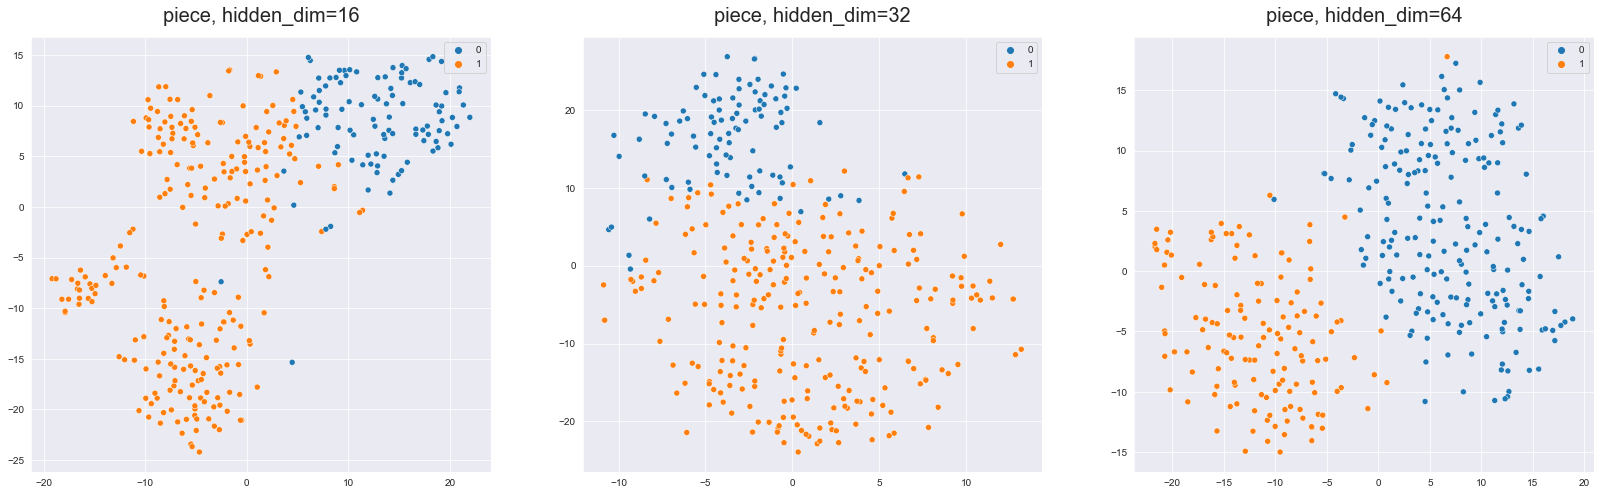

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 8))
axes = axes.ravel()

token = "piece"
# 16
texts, positions, all_token_embeddings_16 = token_info(token, vocab, val_dataset, all_embeddings_16)
y_pred = show_token_info(all_token_embeddings_16, title=token + ", hidden_dim=16", ax=axes[0])
# 32
texts, positions, all_token_embeddings_32 = token_info(token, vocab, val_dataset, all_embeddings_32)
y_pred = show_token_info(all_token_embeddings_32, title=token + ", hidden_dim=32", ax=axes[1])
# 64
texts, positions, all_token_embeddings_64 = token_info(token, vocab, val_dataset, all_embeddings_64)
y_pred = show_token_info(all_token_embeddings_64, title=token + ", hidden_dim=64", ax=axes[2])

  0%|          | 0/63978 [00:00<?, ?it/s]

  0%|          | 0/63978 [00:00<?, ?it/s]

  0%|          | 0/63978 [00:00<?, ?it/s]

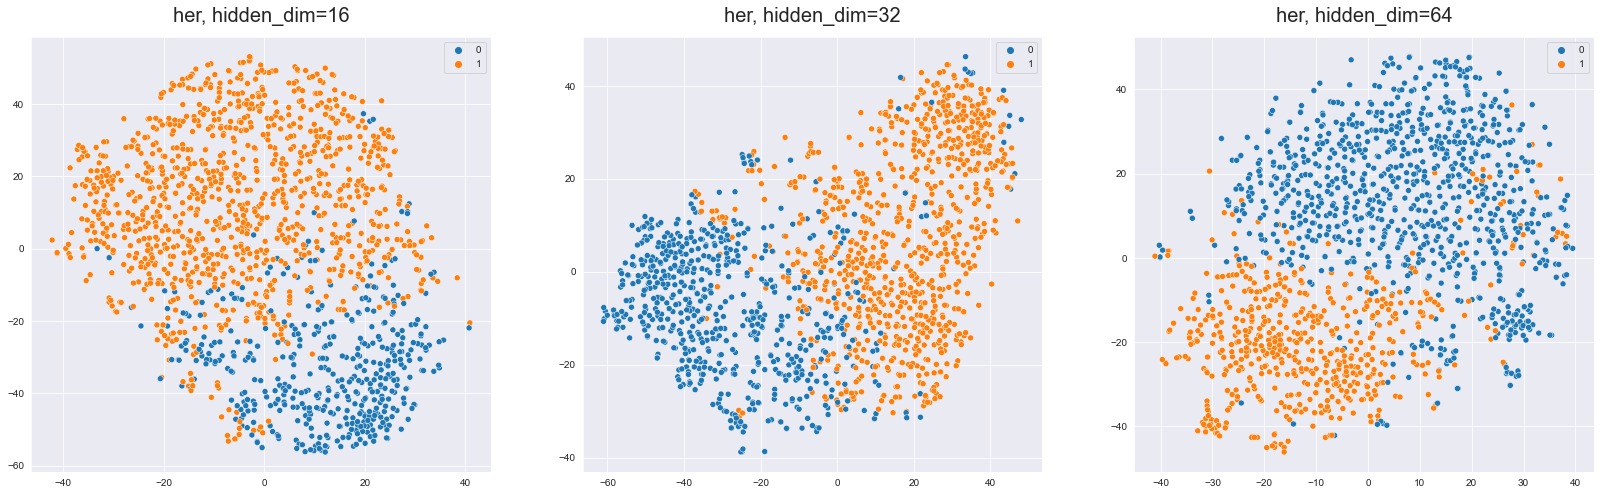

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 8))
axes = axes.ravel()

token = "her"
# 16
texts, positions, all_token_embeddings_16 = token_info(token, vocab, val_dataset, all_embeddings_16)
y_pred = show_token_info(all_token_embeddings_16, title=token + ", hidden_dim=16", ax=axes[0])
# 32
texts, positions, all_token_embeddings_32 = token_info(token, vocab, val_dataset, all_embeddings_32)
y_pred = show_token_info(all_token_embeddings_32, title=token + ", hidden_dim=32", ax=axes[1])
# 64
texts, positions, all_token_embeddings_64 = token_info(token, vocab, val_dataset, all_embeddings_64)
y_pred = show_token_info(all_token_embeddings_64, title=token + ", hidden_dim=64", ax=axes[2])

Интересно, что при маленьком размере скрытого слоя равном 16 очень хорошо выделились кластеры для `post`, складывается такое ощущение, что с ростом размерности для этого слова кластеры разделяются только хуже (что странно). При этом для слова `piece` напротив с ростом размерности кластеры лучше выделяются.

## Оценка качества представлений в задаче классификации текстов

Применим наши контекстные представления в задаче классификаии комментариев. В качестве основной модели будем использовать однослойную BiLSTM.

Загрузим все модели контекстных представлений (с разными размерами скрытых слоев).

In [19]:
from model_utils import RNNClassifier, train, get_results

params = {
    'embedding_dim': 25,
    'vocab': vocab,
    'pretrained_embeddings': pretrained_embeddings,
    'tuning': True,
    'dropout': 0.0,
    'num_layers': 1
}

elmo_16 = ELMo(hidden_dim=16, **params).to(device=device)
elmo_16.load_state_dict(torch.load("./model_16.torch"))
for param in elmo_16.parameters():
    param.requires_grad = False
elmo_16.eval()

elmo_32 = ELMo(hidden_dim=32, **params).to(device=device)
elmo_32.load_state_dict(torch.load("./model_32.torch"))
for param in elmo_32.parameters():
    param.requires_grad = False
elmo_32.eval()

elmo_64 = ELMo(hidden_dim=64, **params).to(device=device)
elmo_64.load_state_dict(torch.load("./model_64.torch"))
for param in elmo_64.parameters():
    param.requires_grad = False
elmo_64.eval()

elmo_128 = ELMo(hidden_dim=128, **params).to(device=device)
elmo_128.load_state_dict(torch.load("./model_128.torch"))
for param in elmo_128.parameters():
    param.requires_grad = False
elmo_128.eval()

ELMo(
  (vocab): Vocab()
  (noncontext_embeddings): Embedding(15004, 25, padding_idx=0)
  (rnn_forward): LSTM(25, 128)
  (rnn_backward): LSTM(25, 128)
  (output_forward): Linear(in_features=128, out_features=15004, bias=True)
  (output_backward): Linear(in_features=128, out_features=15004, bias=True)
)

Обучим классификаторы с контекстными эмбеддингами разного размера. Они довольно быстро переобучаются, поэтому возьмем небольшое число эпох равное 5.

In [9]:
params_clf = {
    'hidden_dim': 128,
    'output_size': 2,
    'vocab': vocab,
    'pretrained_vectors': pretrained_embeddings,
    'tuning': False,
    'dropout': 0.0,
    'num_layers': 1,
    'concat': False,
    'get_emb_f': get_embeddings
}

# 16
rnn_clf_16 = RNNClassifier(embedding_dim=32, elmo=elmo_16, **params_clf).to(device)
# 32
rnn_clf_32 = RNNClassifier(embedding_dim=64, elmo=elmo_32, **params_clf).to(device)
# 64
rnn_clf_64 = RNNClassifier(embedding_dim=128, elmo=elmo_64, **params_clf).to(device)
# 128
rnn_clf_128 = RNNClassifier(embedding_dim=256, elmo=elmo_128, **params_clf).to(device)

In [10]:

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam([ param for param in rnn_clf_16.parameters() if param.requires_grad == True], lr=1e-3)
num_epochs = 5

train_losses_pure, train_accuracies_pure, val_losses_pure, val_accuracies_pure = train(
    train_dataloader, val_dataloader, rnn_clf_16, loss_fn, optimizer, device, num_epochs
)

torch.save(rnn_clf_16.state_dict(), "./rnn_clf_16.torch")

Epoch: 1/5. Loss (Train/Val): 0.169/0.209. Accuracy (Train/Val): 0.938/0.917
Epoch: 2/5. Loss (Train/Val): 0.166/0.217. Accuracy (Train/Val): 0.938/0.914
Epoch: 3/5. Loss (Train/Val): 0.144/0.180. Accuracy (Train/Val): 0.947/0.928
Epoch: 4/5. Loss (Train/Val): 0.135/0.190. Accuracy (Train/Val): 0.950/0.922
Epoch: 5/5. Loss (Train/Val): 0.128/0.183. Accuracy (Train/Val): 0.953/0.924


In [11]:

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam([ param for param in rnn_clf_32.parameters() if param.requires_grad == True], lr=1e-3)
num_epochs = 5

train_losses_pure, train_accuracies_pure, val_losses_pure, val_accuracies_pure = train(
    train_dataloader, val_dataloader, rnn_clf_32, loss_fn, optimizer, device, num_epochs
)

torch.save(rnn_clf_32.state_dict(), "./rnn_clf_32.torch")

Epoch: 1/5. Loss (Train/Val): 0.168/0.214. Accuracy (Train/Val): 0.939/0.917
Epoch: 2/5. Loss (Train/Val): 0.131/0.179. Accuracy (Train/Val): 0.950/0.926
Epoch: 3/5. Loss (Train/Val): 0.117/0.180. Accuracy (Train/Val): 0.956/0.926
Epoch: 4/5. Loss (Train/Val): 0.113/0.167. Accuracy (Train/Val): 0.958/0.932
Epoch: 5/5. Loss (Train/Val): 0.111/0.192. Accuracy (Train/Val): 0.959/0.920


In [12]:

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam([ param for param in rnn_clf_64.parameters() if param.requires_grad == True], lr=1e-3)
num_epochs = 5

train_losses_pure, train_accuracies_pure, val_losses_pure, val_accuracies_pure = train(
    train_dataloader, val_dataloader, rnn_clf_64, loss_fn, optimizer, device, num_epochs
)

torch.save(rnn_clf_64.state_dict(), "./rnn_clf_64.torch")

Epoch: 1/5. Loss (Train/Val): 0.193/0.229. Accuracy (Train/Val): 0.931/0.918
Epoch: 2/5. Loss (Train/Val): 0.163/0.222. Accuracy (Train/Val): 0.944/0.921
Epoch: 3/5. Loss (Train/Val): 0.147/0.216. Accuracy (Train/Val): 0.949/0.920
Epoch: 4/5. Loss (Train/Val): 0.137/0.206. Accuracy (Train/Val): 0.952/0.927
Epoch: 5/5. Loss (Train/Val): 0.123/0.206. Accuracy (Train/Val): 0.956/0.928


In [13]:

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam([ param for param in rnn_clf_128.parameters() if param.requires_grad == True], lr=1e-3)
num_epochs = 5

train_losses_pure, train_accuracies_pure, val_losses_pure, val_accuracies_pure = train(
    train_dataloader, val_dataloader, rnn_clf_128, loss_fn, optimizer, device, num_epochs
)

torch.save(rnn_clf_128.state_dict(), "./rnn_clf_128.torch")

Epoch: 1/5. Loss (Train/Val): 0.173/0.222. Accuracy (Train/Val): 0.939/0.923
Epoch: 2/5. Loss (Train/Val): 0.148/0.209. Accuracy (Train/Val): 0.947/0.927
Epoch: 3/5. Loss (Train/Val): 0.124/0.204. Accuracy (Train/Val): 0.956/0.926
Epoch: 4/5. Loss (Train/Val): 0.105/0.213. Accuracy (Train/Val): 0.964/0.921
Epoch: 5/5. Loss (Train/Val): 0.089/0.223. Accuracy (Train/Val): 0.969/0.922


Данные в соревновании довольно несбалансированы (примерно 10% токсичных комментариев), поэтому вместо точности будем оценивать качество с помощью метрики ROC-AUC (именно она использовалась в соревновании) и F1-score.

In [ ]:

y_prob_16, y_true_16 = get_results(val_dataloader, rnn_clf_16, device)
y_pred_16 = y_prob_16.argmax(dim=1)
f1_16 = f1_score(y_true_16, y_pred_16)
roc_16 = roc_auc_score(y_true_16, y_prob_16[:, 1])

y_prob_32, y_true_32 = get_results(val_dataloader, rnn_clf_32, device)
y_pred_32 = y_prob_32.argmax(dim=1)
f1_32 = f1_score(y_true_32, y_pred_32)
roc_32 = roc_auc_score(y_true_32, y_prob_32[:, 1])

y_prob_64, y_true_64 = get_results(val_dataloader, rnn_clf_64, device)
y_pred_64 = y_prob_64.argmax(dim=1)
f1_64 = f1_score(y_true_64, y_pred_64)
roc_64 = roc_auc_score(y_true_64, y_prob_64[:, 1])

y_prob_128, y_true_128 = get_results(val_dataloader, rnn_clf_128, device)
y_pred_128 = y_prob_128.argmax(dim=1)
f1_128 = f1_score(y_true_128, y_pred_128)
roc_128 = roc_auc_score(y_true_128, y_prob_128[:, 1])

In [21]:
print(f"HIDDEN_SIZE=16: F1-score - {f1_16:.3f}, ROC-AUC - {roc_16:.3f}")
print(f"HIDDEN_SIZE=32: F1-score - {f1_32:.3f}, ROC-AUC - {roc_32:.3f}")
print(f"HIDDEN_SIZE=64: F1-score - {f1_64:.3f}, ROC-AUC - {roc_64:.3f}")
print(f"HIDDEN_SIZE=128: F1-score - {f1_128:.3f}, ROC-AUC - {roc_128:.3f}")

HIDDEN_SIZE=16: F1-score - 0.612, ROC-AUC - 0.935
HIDDEN_SIZE=32: F1-score - 0.637, ROC-AUC - 0.945
HIDDEN_SIZE=64: F1-score - 0.583, ROC-AUC - 0.911
HIDDEN_SIZE=128: F1-score - 0.614, ROC-AUC - 0.922



| Размер представления | F1-метрика | ROC-AUC |
| --- | --- | --- |
| 32 | 0.612 | 0.935 |
| 64 | 0.637 | 0.945 |
| 128 | 0.583 | 0.911 |
| 256 | 0.614 | 0.922 |

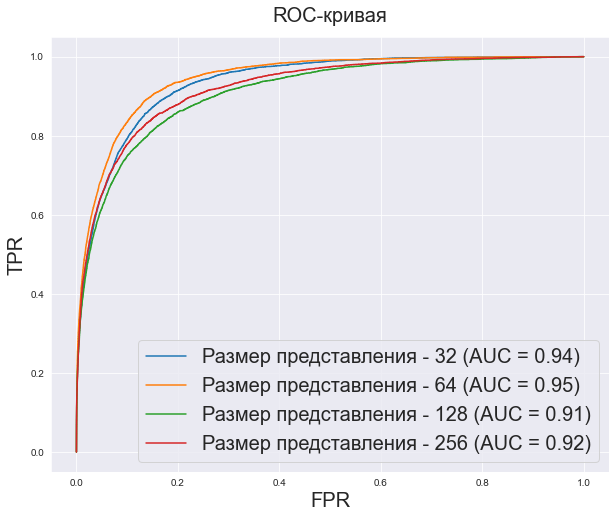

In [35]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.set_style('darkgrid')

RocCurveDisplay.from_predictions(y_true_16, y_prob_16[:, 1], ax=ax, name='Размер представления - 32')
RocCurveDisplay.from_predictions(y_true_32, y_prob_32[:, 1], ax=ax, name='Размер представления - 64')
RocCurveDisplay.from_predictions(y_true_64, y_prob_64[:, 1], ax=ax, name='Размер представления - 128')
RocCurveDisplay.from_predictions(y_true_128, y_prob_128[:, 1], ax=ax, name='Размер представления - 256')

plt.legend(fontsize=20)
plt.title("ROC-кривая", fontsize=20, pad=15)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)

plt.show()

При более маленьких размерах представления (32 и 64) качество получилось заметно лучше чем при больших (128 и 256).

## Сравнение качества при использовании контекстных и неконтекстных представлений

Также интересно сравнить результаты полученные с использованием контекстных представлений с аналогичными результатами при использовании неконтекстных представлений.

Обучим еще 2 классификатора, но теперь не будем использовать наши контекстные представления, а возьмем только предобученные представления GloVe. В одном будем дообучать представления, а в другом не будем.

In [38]:
params_clf = {
    'embedding_dim': 25,
    'hidden_dim': 128,
    'output_size': 2,
    'vocab': vocab,
    'pretrained_vectors': pretrained_embeddings,
    'dropout': 0.0,
    'elmo': None,
    'num_layers': 1,
    'concat': False,
    'get_emb_f': get_embeddings
}

# True
rnn_clf_true = RNNClassifier(tuning=True, **params_clf).to(device)
# False
rnn_clf_false = RNNClassifier(tuning=False, **params_clf).to(device)


In [40]:

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam([ param for param in rnn_clf_true.parameters() if param.requires_grad == True], lr=1e-3)
num_epochs = 5

train_losses_pure, train_accuracies_pure, val_losses_pure, val_accuracies_pure = train(
    train_dataloader, val_dataloader, rnn_clf_true, loss_fn, optimizer, device, num_epochs
)

torch.save(rnn_clf_true.state_dict(), "./rnn_clf_true.torch")

Epoch: 1/5. Loss (Train/Val): 0.101/0.237. Accuracy (Train/Val): 0.962/0.903
Epoch: 2/5. Loss (Train/Val): 0.087/0.225. Accuracy (Train/Val): 0.968/0.909
Epoch: 3/5. Loss (Train/Val): 0.075/0.185. Accuracy (Train/Val): 0.972/0.923
Epoch: 4/5. Loss (Train/Val): 0.066/0.198. Accuracy (Train/Val): 0.975/0.920
Epoch: 5/5. Loss (Train/Val): 0.058/0.207. Accuracy (Train/Val): 0.978/0.919


In [42]:

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam([ param for param in rnn_clf_false.parameters() if param.requires_grad == True], lr=1e-3)
num_epochs = 5

train_losses_pure, train_accuracies_pure, val_losses_pure, val_accuracies_pure = train(
    train_dataloader, val_dataloader, rnn_clf_false, loss_fn, optimizer, device, num_epochs
)

torch.save(rnn_clf_false.state_dict(), "./rnn_clf_false.torch")

Epoch: 1/5. Loss (Train/Val): 0.147/0.188. Accuracy (Train/Val): 0.948/0.924
Epoch: 2/5. Loss (Train/Val): 0.134/0.186. Accuracy (Train/Val): 0.952/0.922
Epoch: 3/5. Loss (Train/Val): 0.125/0.189. Accuracy (Train/Val): 0.955/0.923
Epoch: 4/5. Loss (Train/Val): 0.122/0.194. Accuracy (Train/Val): 0.957/0.919
Epoch: 5/5. Loss (Train/Val): 0.112/0.180. Accuracy (Train/Val): 0.960/0.926


In [43]:
y_prob_true, y_true_true = get_results(val_dataloader, rnn_clf_true, device)
y_pred_true = y_prob_true.argmax(dim=1)
f1_true = f1_score(y_true_true, y_pred_true)
roc_true = roc_auc_score(y_true_true, y_prob_true[:, 1])

y_prob_false, y_true_false = get_results(val_dataloader, rnn_clf_false, device)
y_pred_false = y_prob_false.argmax(dim=1)
f1_false = f1_score(y_true_false, y_pred_false)
roc_false = roc_auc_score(y_true_false, y_prob_false[:, 1])

In [44]:
print(f"TUNING=True: F1-score - {f1_true:.3f}, ROC-AUC - {roc_true:.3f}")
print(f"Tuning=False: F1-score - {f1_false:.3f}, ROC-AUC - {roc_false:.3f}")


TUNING=True: F1-score - 0.647, ROC-AUC - 0.955
Tuning=False: F1-score - 0.650, ROC-AUC - 0.946



| С дообучением | F1-метрика | ROC-AUC |
| --- | --- | --- |
| Да | 0.647 | 0.955 |
| Нет | 0.650 | 0.946 |

Изобразим все ROC-кривые на одном графике.

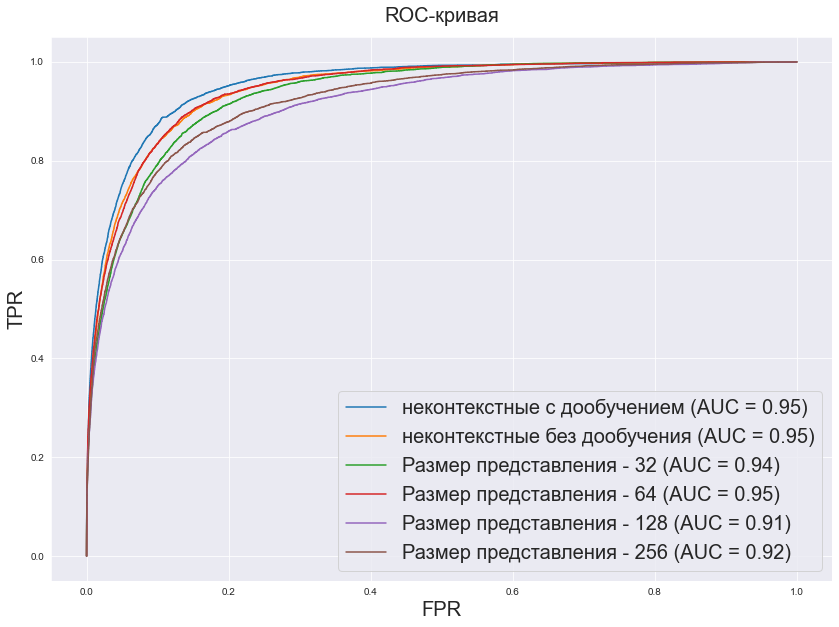

In [47]:

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.set_style('darkgrid')

RocCurveDisplay.from_predictions(y_true_true, y_prob_true[:, 1], ax=ax, name='неконтекстные с дообучением')
RocCurveDisplay.from_predictions(y_true_false, y_prob_false[:, 1], ax=ax, name='неконтекстные без дообучения')
RocCurveDisplay.from_predictions(y_true_16, y_prob_16[:, 1], ax=ax, name='Размер представления - 32')
RocCurveDisplay.from_predictions(y_true_32, y_prob_32[:, 1], ax=ax, name='Размер представления - 64')
RocCurveDisplay.from_predictions(y_true_64, y_prob_64[:, 1], ax=ax, name='Размер представления - 128')
RocCurveDisplay.from_predictions(y_true_128, y_prob_128[:, 1], ax=ax, name='Размер представления - 256')

plt.legend(fontsize=20)
plt.title("ROC-кривая", fontsize=20, pad=15)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)

plt.show()

Как мы видим, качество при использовании контекстных представлений получилось хуже. Даже лучший из рассмотреных вариантов (размер представления 64) немного отстает от неконтекстных.
Анализируя ROC-кривые, можно заметить, что на самом деле использование неконтекстных представлений с дообучением получается существенно лучше (кривая существенно более выпукла к левому верхнему углу чем остальные).
Также стоит отметить то, что контекстные представления, которые обучались на тех же данных, для которых происходит классификация, а также неконтекстные при дообучении, очень быстро переобучаются, что не так заметно при использовании неконтекстных представлений без дообучения.

## Выводы

* Было продемонстрировано, что даже простые контекстные представления действительно спосбны учитывать контекст токена. Это их несомненное преимущество перед неконтекстными, так как последние используют одно и то же представление для токена, даже если он несет разный смысл. Поэтому потенциально контекстные представления "мощнее" чем неконтекстные.

* Однако при использовании контекстных представлений в конкретной задаче качество (как F1-метрика, так и ROC-AUC) получилось хуже чем при использовании неконтекстных. Недостаточно просто брать скрытые состояния с последнего слоя LSTM, возможно стоит более сложным образом агрегировать информацию с разных слоев, а также использовать неконтекстные представления при агрегации (так и делается в оригинальной статье ELMo). Хотя даже такой простой подход, который использовался в нашей реализации позволил добиться качества сравнимого с использованием неконтекстных представлений без дообучения (их ROC-кривые очень похожи).

* Не стоит использовать большие размеры контекстных представлений, с ними качество получилось хуже. Хотя оптимальный размер вероятно будет различным для данных разного объема и сложности. В экспериметах лучшие результаты получились при размере представлений 32 и 64. 

* При наличии небольшого количества обучающих данных и/или вычислительных ресурсов кажется более разумным не обучать контекстные представления, а провести грамотное дообучение предобученных неконтекстных представлений.
